<a href="https://colab.research.google.com/github/harnalashok/Clustering/blob/master/uber_trips_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 6th Sep, 2022
My folder: D:\data\OneDrive\Documents\uber

           /home/ashok/Documents/4.clustering
           
DataSource:
             https://github.com/fivethirtyeight/uber-tlc-foil-response/tree/master/uber-trip-data   
             https://github.com/caroljmcdonald/spark-ml-kmeans-uber  
                   

Ref: knuggets 
    https://www.kdnuggets.com/2020/07/clustering-rideshare-data-uber.html
    Aurelion Book: https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb

Ref: Using pyspark
    https://github.com/mutukulasureshkumar/K-Means_Clustering_PySpark

Objectives: 
#           1. Use Uber data to perform clustering
               and advise Uber of possible locations to
               use as hub for taxis
            2. Process data in a manner done for
               out-of-core machine learning.
            3. Use MiniBatchKMeans()

"""

### Problem
Uber Technologies Inc. is a peer-to-peer ride sharing platform. Uber's platform connects the drivers who can drive to a customer's location. Uber uses machine learning, for calculating pricing to finding the optimal positioning of cars to maximizing profits. We have used the public Uber trip dataset to discuss building a real-time example for analysis and monitoring of car GPS data.

The Uber trip dataset contains data generated by Uber from New York City. The data is freely available on [FiveThirtyEight](https://data.fivethirtyeight.com/).

### A. Software install & Call libraries

In [146]:
# 0.0 Let therebe display from multiple commands
#     from a jupyter cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [147]:
# 0.1 Should be 1.5
import yellowbrick
yellowbrick.__version__     # Should be: 1.5

# 0.2 Should be 0.12.1
import folium
folium.__version__          # Should be: 0.12.1.post1

'1.5'

'0.12.1.post1'

In [148]:
# 0.3 IF not correct versions, 
#     install desied versions
#!pip install yellowbrick==1.3
#!pip install folium==0.12.1

In [149]:
# 1.0 Call libraries
%reset -f
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# 1.1 Visualization
import matplotlib.pyplot as plt
# conda install -c conda-forge folium
import folium

# conda install -c districtdatalabs yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import silhouette_visualizer
# 1.2
import os,time


In [150]:
# 1.3 Check
import yellowbrick
yellowbrick.__version__   # 1.5

# 1.3.1
import folium
folium.__version__        # 0.12.1.post1

'1.5'

'0.12.1.post1'

### B. Mount gdrive

In [151]:
# 1.4 Connect to your google drive

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [152]:
# 2.0 Read data. Set pathToFolder where file uber_raw_data_apr_sep2014.csv.zip
#     is placed


pathToFolder = "/gdrive/MyDrive/Colab_data_files/uber/"



In [153]:
# 2.0.1 MAke out data folder working directory:

os.chdir(pathToFolder)

### C. Read data

In [154]:
# 2.1 Read uber data:

data = pd.read_csv(
                   pathToFolder + "uber_raw_data_apr_sep2014.csv.zip",
                   names =["dtime","lat","long","base"]
                   )



In [155]:
# 2.1.1 Look at the data:

data.shape    # (4534327, 4) 45lakh rows
data.head()
data.dtypes

(4534327, 4)

,dtime,lat,long,base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


dtime     object
lat      float64
long     float64
base      object
dtype: object

The dataset has 45 lakh observations and four columns. It has four attributes:

> **Date/Time:** The date and time of the Uber pickup.<br>
**Lat(Latitude)**: The latitude of the Uber pickup<br>
**Lon(Longitude)**: The longitude of the Uber pickup.<br>
**Base**: the TLC base company code affiliated with the Uber pickup. <br>

### D. Store file to disk as memory-map


Create a memory-map to an array stored in a binary file on disk. Refer [here](https://numpy.org/doc/stable/reference/generated/numpy.memmap.html).<br>
Memory-mapped files are used for accessing small segments of large files on disk, without reading the entire file into memory. NumPy’s memmap’s are array-like objects. This differs from Python’s mmap module, which uses file-like objects.

Flush the memmap instance to write the changes to the file. Currently there is no API to *close* the underlying mmap. It is tricky to ensure the resource is actually closed, since it may be shared between different memmap instances.

In [156]:
# 2.2 We need only two columns
#     to perform clustering:

clus = data[["lat","long"]]

# 2.2.1 IF your RAM is large, take
#       ,say, first 10000 rows
clus = clus[:]     # clus = clus[:100000]

In [157]:
# 2.2.2 If a memmap file (.npy) already exists
#       delete it first:

! pwd
! rm -f *.npy
! ls -la

/gdrive/MyDrive/Colab_data_files/uber
total 30094
-rw------- 1 root root 30815362 Mar 25  2021 uber_raw_data_apr_sep2014.csv.zip


In [158]:
# 2.3 Create a memcap file
#     to store data of clus.shape
#     It is a zero-filled file

# https://numpy.org/doc/stable/reference/generated/numpy.memmap.html

clus_file = np.memmap('clus_mem.npy',
                      dtype='float32',
                      mode='w+',
                      shape=clus.shape
                      )

In [159]:
# 2.3.1 Check if file created

! ls -la

total 65518
-rw------- 1 root root 36274616 Sep  7 07:39 clus_mem.npy
-rw------- 1 root root 30815362 Mar 25  2021 uber_raw_data_apr_sep2014.csv.zip


In [160]:
# 2.3.2 And what all this file contains:

clus_file[:5]


memmap([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32)

In [161]:
# 2.4 Now fill this file with our data:

clus_file[:]= clus

In [162]:
# 2.4.1 Check again:

clus_file[:3]

memmap([[ 40.769 , -73.9549],
        [ 40.7267, -74.0345],
        [ 40.7316, -73.9873]], dtype=float32)

In [163]:
# 2.4.2 And check file:

! ls -la

total 65518
-rw------- 1 root root 36274616 Sep  7 07:39 clus_mem.npy
-rw------- 1 root root 30815362 Mar 25  2021 uber_raw_data_apr_sep2014.csv.zip


In [164]:
# 2.4.3 Delete our files
#       in RAM:

del clus
del data

# 2.4.4 And flush memcap file from RAM:

clus_file.flush()

### E. Read mammap file and process data

In [165]:
# 3.0 Open memmap file in read mode:
clus_read = np.memmap(
                      'clus_mem.npy',
                      dtype='float32',
                      mode='r',
                      shape=(4534327, 2)
                      )


In [166]:
# 3.1
clus_read.shape
print()
# 3.2
clus_read[:4]

(4534327, 2)

memmap([[ 40.769 , -73.9549],
        [ 40.7267, -74.0345],
        [ 40.7316, -73.9873],
        [ 40.7588, -73.9776]], dtype=float32)

In [167]:
# 3.3 Here is how we will shuffle data:

x = np.arange(clus_read.shape[0])
x[:4]
print("")
# 3.3.1 Shuffle 'x' in place
np.random.shuffle(x)
x[:4]

array([0, 1, 2, 3])

array([ 175970, 1661674, 4033949, 1516521])

In [168]:
# 3.4 Our shuffled set
#     of 1lakh rows

clus = clus_read[x[:100000]]
clus.shape

(100000, 2)

###F. How many clusters?

In [169]:
# 4.0 What should be the number of clusters?
#     We will use data of size 1 lakh:

inertia = []
s_score = []
start = time.time()

# 4.1
for i in range(2,10):

    # 4.1.1 Pick random data from memmap
    x = np.arange(clus_read.shape[0])
    np.random.shuffle(x)
    clus = clus_read[x[:100000]]

    # 4.1.2 The model
    model = KMeans(
                    n_clusters = i,
                    max_iter = 300)
    model.fit(clus)     

    # 4.1.3 Store inertia value
    inertia.append(model.inertia_)
    
    # 4.1.4 Calculate silhoutte score
    t=silhouette_score(clus, model.labels_, sample_size = 1000)
    s_score.append(t)
    print()

end = time.time()
(end-start)/60    # 7minutes

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

0.20821192264556884

### G.Scree plot and Silhoutte score

In [170]:
# 4.2 Values of inertia
inertia



[292.04046630859375,
 229.9252471923828,
 194.5144805908203,
 147.776123046875,
 120.47090911865234,
 103.56015014648438,
 87.99750518798828,
 77.44203186035156]

<Figure size 576x396 with 0 Axes>

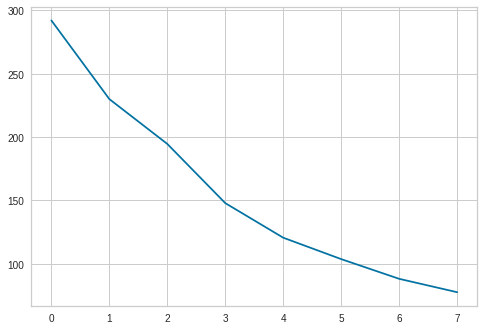

In [171]:
# 4.3 Elbow plot
plt.figure()
plt.plot(inertia)
plt.show()

From the above elbow plot, we can see that 
the sum of the squared distance of the 
observations from their closest cluster 
centroid keeps decreasing with an increase 
in the number of clusters. We can see that 
after K=6 there is a significant reduction. 
We can choose either 6 or 7 clusters, and for 
this application we have chosen 6.


In [172]:
# 4.4 Values of silhoutte score

s_score

[0.71667886,
 0.38419703,
 0.387044,
 0.4177369,
 0.44646296,
 0.43736267,
 0.44639343,
 0.42958575]

<Figure size 576x396 with 0 Axes>

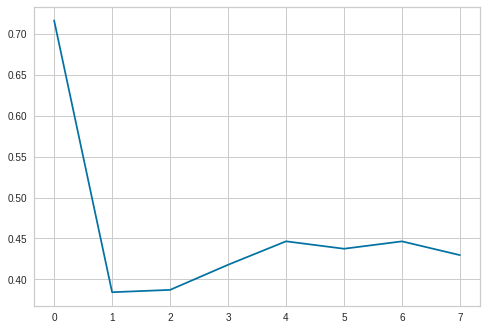

In [173]:
# 4.5 Silhoutte score plot:

plt.figure()
plt.plot(s_score)
plt.show()

### H. Final model
We will use `MiniBatchKMeans`. It is much faster! However, its performance is often lower (higher inertia), and it keeps degrading as k increases. See more here.

In [174]:
# 5.0 Perform clustering with 6 clusters
#     MinBatchKMEans converges very fast:

model = KMeans(
                    n_clusters=6,
                    max_iter=1000
                )
# 5.1
model.fit(clus_read)


KMeans(max_iter=1000, n_clusters=6)

In [175]:
# 5.2 About the model
#     We get labels about all
#     45-lakh rows not just 1-lakh
#     or bacth-size

len(model.labels_)
print()

# 5.2.1
model.inertia_
print()

4534327

5525.0654296875

In [176]:
# 5.3 Create a new column
#     in 'fpr' memap

clus_read = np.hstack(
                     [ clus_read,
                       model.labels_.reshape(model.labels_.shape[0],1)
                     ]
                )

# 5.3.1 Check
clus_read.shape

(4534327, 3)

#### Silhoutte score calculation

In [177]:
# 6.0 Shuffle data
x = np.arange(clus_read.shape[0])
np.random.shuffle(x)
clus_read = clus_read[x]

In [178]:
# 3.3 Mean silhoutte score
data_size = 100000
silhouette_score(
                 clus_read[:data_size,:2],
                 model.labels_[:data_size],
                 sample_size=50000   # For calculation of silhoutte score
                 )

-0.03090435410661838

#### Silhoutte plot

In [179]:
# 4.0
# Ref: https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

visualizer = SilhouetteVisualizer(
                                  model,
                                  colors='yellowbrick'
                                  )

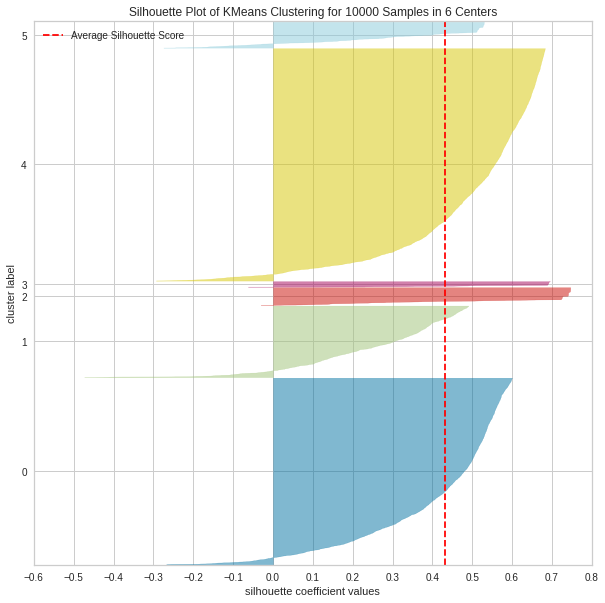

0.06199469566345215

In [180]:
# 4.1
fig = plt.figure(figsize= (10,10))
start = time.time()
_= visualizer.fit(clus[:10000])        # Fit the data to the visualizer
_= visualizer.show()        # Finalize and render the figure
end = time.time()
(end-start)/60


#### Cluster centroids on map

In [181]:
# 5.0
centroids = model.cluster_centers_

# 5.1 Transform  centroids to a DataFrame
clocation = pd.DataFrame(
                         centroids,
                         columns = ["Latitude", "Longitude"]
                         )

# 5.1.1
clocation

,Latitude,Longitude
0,40.767345,-73.972778
1,40.686714,-73.963295
2,40.664829,-73.761986
3,40.698185,-74.202560
4,40.729996,-73.997459
5,40.794525,-73.872025


In [182]:
# 5.2 What are mean centroid values
lat_mean = clocation['Latitude'].mean()
long_mean = clocation['Longitude'].mean()

In [183]:
# 5.3 Converting centroid into lists
centroid = clocation.values.tolist()

# 5.1 Plotting the centroids on google map using Folium library.
map = folium.Map(
                  # Center the map here
                  location=[lat_mean,long_mean],
                  zoom_start = 10
                )

# 5.2 
for point in range(0, len(centroid)):
    abc=folium.Marker(
                      centroid[point],
                      popup = centroid[point]
                      ).add_to(map)

    

In [184]:
# 5.3 Draw google map
map

#### Conclusions

We can see that all the six centroids have been plotted on the map. How are these centroids helpful for Uber?

>    Uber can use these centroids as their hubs. Whenever Uber receives a new ride request, they can check the closeness with each of these centroids. Whichever particular centroid is closer, Uber can direct the vehicle from that particular location to the customer location.<br>

>    Uber has many drivers and provides services to many locations. If Uber knows the hub (particular centroid), and if they are getting a lot of ride request then strategically they can place their drivers in better locations wherein their probability of getting a ride request is greater. This will help Uber to serve the customer faster as vehicles are placed closer to the location and also help to grow their business.<br>

>   Uber can make use of these centroids for the optimal placing of their vehicles. They can find which centroid at which part of the day have more ride requests. For example, if Uber gets more request from centroid 0 (cluster 1) at 11 AM, but far fewer requests from centroid 3 (cluster 4), then they can redirect the vehicles to cluster 1 from cluster 4 (if there is an increased vehicle presence in cluster 4).<br>

>   Uber can use these centroids for optimal pricing by analyzing which cluster deals with maximum requests, peak times etc. Suppose they don’t have many vehicles available to be sent to a particular location (more demand), then they can do optimal pricing as demand is high and supply is less. <br>

In [185]:
# https://seaborn.pydata.org/generated/seaborn.catplot.html
_= sns.catplot(
                   data = clus,
                   x = 'Clusters',
                   kind = 'count',
                   size = 7,
                   order = [2,0,4,5,1,3] # Order of display
                  )

NameError: ignored

In [ ]:
# 3.0 Predicting on a new location
new_location = [(40.6556,-73.5631)]
kmeans.predict(new_location)

In [ ]:
####### I am done ################